In [2]:
import sys

sys.path.append("../libs")


CONFIG = {
    "model_path": "../data/model/model_baseline.joblib",
    "features_path": "../data/model/baseline_features_list.json",
    "feature_dataset_database_file": "../data/feature_store.db",
}

In [3]:
import joblib

model = joblib.load(CONFIG["model_path"])

In [4]:
import json

with open(CONFIG["features_path"], 'r') as f:
    features = json.load(f)
features

['funded_amnt',
 'term',
 'installment',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl'

In [5]:
from feature_dataset import FeatureDataset
import pandas as pd
fs = FeatureDataset(CONFIG['feature_dataset_database_file'])

df_train: pd.DataFrame = fs.get_feature_dataset(name="training", version=1)

In [6]:
df_train['target'].describe()

count    823495.000000
mean          0.179438
std           0.383719
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [7]:
df_train['time_of_banking_days'] = (df_train['issue_d'] - df_train['earliest_cr_line']).dt.days
df_train['time_of_banking_months'] = (df_train['issue_d'].dt.year - df_train['earliest_cr_line'].dt.year) * 12 + (df_train['issue_d'].dt.month - df_train['earliest_cr_line'].dt.month)

In [8]:
df_train['emp_length'] = df_train['emp_length'].str.replace(' years', '').str.replace(' year', '').str.replace('< 1', '0').str.replace('+', '').astype(float)

In [9]:
cat_features = [
    "emp_length",
    "home_ownership",
    "verification_status",
    "purpose",
    "addr_state",
    "application_type",
]
df_train[cat_features] = df_train[cat_features].astype(str).fillna('missing')

In [10]:
df_train.head()

,id,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,default,time_of_banking_days,time_of_banking_months,target
0,87023,7500,7500,36,255.375,0.0,OWN,22000.0,Not Verified,2007-06-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,1339,44,0.0
1,92533,5000,5000,36,164.250,0.0,OWN,80000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,4017,132,0.0
2,93277,3000,3000,36,95.000,0.0,MORTGAGE,25000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,2494,82,0.0
3,93061,5000,5000,36,155.375,8.0,MORTGAGE,120000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,3560,117,0.0
4,92676,5000,5000,36,156.875,0.0,MORTGAGE,180000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,4047,133,0.0


In [11]:
# Drop rows with missing target values
df_train = df_train.dropna(subset=["target"])

In [12]:
df_train.head()

,id,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,default,time_of_banking_days,time_of_banking_months,target
0,87023,7500,7500,36,255.375,0.0,OWN,22000.0,Not Verified,2007-06-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,1339,44,0.0
1,92533,5000,5000,36,164.250,0.0,OWN,80000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,4017,132,0.0
2,93277,3000,3000,36,95.000,0.0,MORTGAGE,25000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,2494,82,0.0
3,93061,5000,5000,36,155.375,8.0,MORTGAGE,120000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,3560,117,0.0
4,92676,5000,5000,36,156.875,0.0,MORTGAGE,180000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,4047,133,0.0


Baseline Model

In [13]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import log_loss, average_precision_score

X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train["target"], test_size=0.2, random_state=42)

#X_train[cat_features] = X_train[cat_features].astype(str).fillna('missing')

#X_test[cat_features] = X_test[cat_features].astype(str).fillna('missing')

# Identify categorical features
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to string (just in case)
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Initialize and train CatBoost classifier
model = CatBoostClassifier(iterations = 1000,
                            auto_class_weights = "Balanced",
                            eval_metric = "PRAUC:use_weights=false",
                            cat_features = cat_features,
                            verbose = True,
                            random_seed = 42,
                            max_depth = 8,
                            colsample_bylevel = 0.8,
                            subsample = 0.7,
                            learning_rate = 0.02,
                            early_stopping_rounds = 100)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
logloss = log_loss(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"Log Loss: {logloss:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

0:	learn: 0.6825798	total: 231ms	remaining: 3m 50s
1:	learn: 0.6753294	total: 390ms	remaining: 3m 14s
2:	learn: 0.6879107	total: 577ms	remaining: 3m 11s
3:	learn: 0.6882074	total: 736ms	remaining: 3m 3s
4:	learn: 0.6896500	total: 891ms	remaining: 2m 57s
5:	learn: 0.6902331	total: 1.03s	remaining: 2m 51s
6:	learn: 0.6906387	total: 1.2s	remaining: 2m 50s
7:	learn: 0.6912094	total: 1.38s	remaining: 2m 51s
8:	learn: 0.6903543	total: 1.53s	remaining: 2m 48s
9:	learn: 0.6920852	total: 1.71s	remaining: 2m 49s
10:	learn: 0.6927793	total: 1.86s	remaining: 2m 47s
11:	learn: 0.6924460	total: 2.04s	remaining: 2m 48s
12:	learn: 0.6933847	total: 2.23s	remaining: 2m 49s
13:	learn: 0.6940937	total: 2.41s	remaining: 2m 49s
14:	learn: 0.6948014	total: 2.59s	remaining: 2m 50s
15:	learn: 0.6943580	total: 2.78s	remaining: 2m 50s
16:	learn: 0.6945998	total: 2.97s	remaining: 2m 51s
17:	learn: 0.6946357	total: 3.16s	remaining: 2m 52s
18:	learn: 0.6943404	total: 3.35s	remaining: 2m 52s
19:	learn: 0.6942537	tot

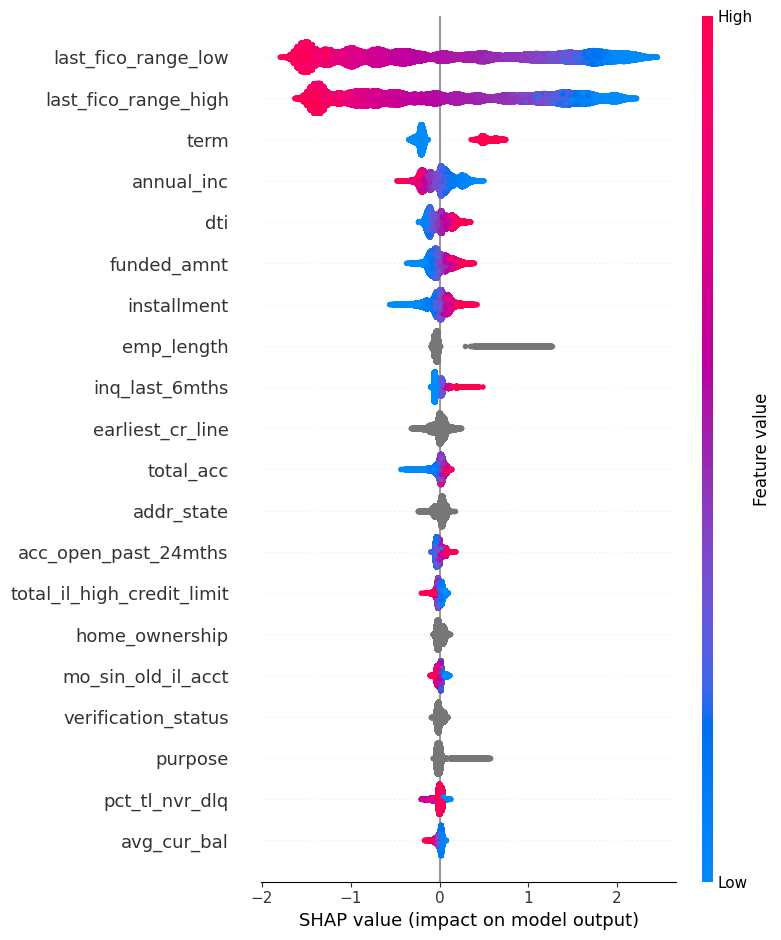

In [14]:
# SHAP Analysis
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

Hyperparameter Tuning

Tuning by Log Loss

In [15]:
import optuna

# Types for tuning hipeparameters: https://www.linkedin.com/posts/timurbikmukhametov_9-practical-tips-for-tuning-gradient-boosting-activity-7285985903984955392-IRHR?utm_source=share&utm_medium=member_desktop
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 750, 1000,1500]),
        'max_depth': trial.suggest_int('depth', 4, 12),
        'early_stopping_rounds': 50,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),  # Regularization
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Regularization
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reducing overfitting
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['None', 'Balanced', 'SqrtBalanced']),
        'verbose': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
    }

    # Identify categorical features
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    # Convert categorical features to string (just in case)
    for col in cat_features:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    model = CatBoostClassifier(**params)
    model.fit(
    X_train, y_train,
    cat_features=cat_features,  # ✅ Make sure this list is correct
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
    )

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate model
    logloss = log_loss(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Store them in user_attrs
    trial.set_user_attr("log_loss", logloss)
    trial.set_user_attr("pr_auc", pr_auc)

    #return logloss + (1 - pr_auc) # Minimize logloss while maximizing PR-AUC
    return logloss

study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

print('Tuning the model...')
study.optimize(objective, timeout=3600, n_trials=None)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-02-10 23:46:01,572] A new study created in memory with name: no-name-c6c10a2a-5d11-4e59-8928-d638eaf45c32


Tuning the model...


[I 2025-02-10 23:46:49,627] Trial 0 finished with value: 0.25288492963206477 and parameters: {'iterations': 1000, 'depth': 7, 'l2_leaf_reg': 0.010129106606001881, 'bagging_temperature': 0.8588545989797153, 'random_strength': 0.05831016954748732, 'colsample_bylevel': 0.9091041618012977, 'subsample': 0.5012346191739512, 'auto_class_weights': 'None', 'learning_rate': 0.11900891615113991}. Best is trial 0 with value: 0.25288492963206477.
[I 2025-02-10 23:48:12,628] Trial 1 finished with value: 0.28773981553774913 and parameters: {'iterations': 750, 'depth': 7, 'l2_leaf_reg': 0.2615325121857925, 'bagging_temperature': 0.7521627448910906, 'random_strength': 0.009268364938071224, 'colsample_bylevel': 0.6285882653734438, 'subsample': 0.6098173274222416, 'auto_class_weights': 'SqrtBalanced', 'learning_rate': 0.003234517995058643}. Best is trial 0 with value: 0.25288492963206477.
[I 2025-02-10 23:49:20,620] Trial 2 finished with value: 0.26553778755394847 and parameters: {'iterations': 300, 'dep

Best parameters: {'iterations': 1500, 'depth': 10, 'l2_leaf_reg': 7.519867011663144, 'bagging_temperature': 0.06522479072002263, 'random_strength': 1.0373034782420635e-06, 'colsample_bylevel': 0.9985968073271833, 'subsample': 0.838505857908814, 'auto_class_weights': 'None', 'learning_rate': 0.035308682185235266}


In [16]:
import json

print('Saving the best parameters to a JSON file...\n ', json.dumps(best_params, indent=4))

Saving the best parameters to a JSON file...
  {
    "iterations": 1500,
    "depth": 10,
    "l2_leaf_reg": 7.519867011663144,
    "bagging_temperature": 0.06522479072002263,
    "random_strength": 1.0373034782420635e-06,
    "colsample_bylevel": 0.9985968073271833,
    "subsample": 0.838505857908814,
    "auto_class_weights": "None",
    "learning_rate": 0.035308682185235266
}


In [17]:
df_results = pd.DataFrame(
    [
        {
            "trial": t.number,
            "value": t.value,
            "log_loss": t.user_attrs.get("log_loss"),
            "pr_auc": t.user_attrs.get("pr_auc"),
            **t.params,
        }
        for t in study.trials
    ]
)

print(df_results[["trial", "value", "log_loss", "pr_auc"]])

    trial     value  log_loss    pr_auc
0       0  0.252885  0.252885  0.723189
1       1  0.287740  0.287740  0.709238
2       2  0.265538  0.265538  0.711744
3       3  0.352539  0.352539  0.721182
4       4  0.256900  0.256900  0.716358
5       5  0.254068  0.254068  0.721342
6       6  0.252669  0.252669  0.723805
7       7  0.279679  0.279679  0.719289
8       8  0.354929  0.354929  0.712757
9       9  0.348049  0.348049  0.720170
10     10  0.251663  0.251663  0.725956
11     11  0.251676  0.251676  0.725891


Tuning by Log Loss + (1 - PRAUC)

In [18]:
# Types for tuning hipeparameters: https://www.linkedin.com/posts/timurbikmukhametov_9-practical-tips-for-tuning-gradient-boosting-activity-7285985903984955392-IRHR?utm_source=share&utm_medium=member_desktop
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 750, 1000,1500]),
        'max_depth': trial.suggest_int('depth', 4, 12),
        'early_stopping_rounds': 50,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),  # Regularization
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Regularization
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reducing overfitting
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['None', 'Balanced', 'SqrtBalanced']),
        'verbose': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
    }

    # Identify categorical features
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    # Convert categorical features to string (just in case)
    for col in cat_features:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    model = CatBoostClassifier(**params)
    model.fit(
    X_train, y_train,
    cat_features=cat_features,  # ✅ Make sure this list is correct
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
    )

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate model
    logloss = log_loss(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Store them in user_attrs
    trial.set_user_attr("log_loss", logloss)
    trial.set_user_attr("pr_auc", pr_auc)

    return logloss + (1 - pr_auc) # Minimize logloss while maximizing PR-AUC

study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

print('Tuning the model...')
study.optimize(objective, timeout=3600, n_trials=None)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-02-11 00:48:53,099] A new study created in memory with name: no-name-bdaa53a7-d411-4dfb-bdf4-8286f6dd34c5


Tuning the model...


[I 2025-02-11 01:24:06,190] Trial 0 finished with value: 0.6269194282843816 and parameters: {'iterations': 1000, 'depth': 10, 'l2_leaf_reg': 0.018331925583105924, 'bagging_temperature': 0.9529379373894377, 'random_strength': 0.005958253192157181, 'colsample_bylevel': 0.9637582413011383, 'subsample': 0.8656864714606192, 'auto_class_weights': 'Balanced', 'learning_rate': 0.014042198723217771}. Best is trial 0 with value: 0.6269194282843816.
[I 2025-02-11 01:39:54,904] Trial 1 finished with value: 0.5644919738641868 and parameters: {'iterations': 300, 'depth': 4, 'l2_leaf_reg': 3.6305569753587132, 'bagging_temperature': 0.8007949917435834, 'random_strength': 7.377734220632068e-09, 'colsample_bylevel': 0.9655432489292293, 'subsample': 0.6544494465910669, 'auto_class_weights': 'None', 'learning_rate': 0.007775048059711186}. Best is trial 1 with value: 0.5644919738641868.
[I 2025-02-11 01:41:06,177] Trial 2 finished with value: 0.5554287631680961 and parameters: {'iterations': 300, 'depth': 

Best parameters: {'iterations': 1000, 'depth': 12, 'l2_leaf_reg': 6.746177457576027, 'bagging_temperature': 0.8742701385986703, 'random_strength': 1.396267713352505e-06, 'colsample_bylevel': 0.9806866307913759, 'subsample': 0.8259950282990149, 'auto_class_weights': 'SqrtBalanced', 'learning_rate': 0.03666539436503066}


In [19]:
print('Saving the best parameters to a JSON file...\n ', json.dumps(best_params, indent=4))

Saving the best parameters to a JSON file...
  {
    "iterations": 1000,
    "depth": 12,
    "l2_leaf_reg": 6.746177457576027,
    "bagging_temperature": 0.8742701385986703,
    "random_strength": 1.396267713352505e-06,
    "colsample_bylevel": 0.9806866307913759,
    "subsample": 0.8259950282990149,
    "auto_class_weights": "SqrtBalanced",
    "learning_rate": 0.03666539436503066
}


In [20]:
df_results = pd.DataFrame(
    [
        {
            "trial": t.number,
            "value": t.value,
            "log_loss": t.user_attrs.get("log_loss"),
            "pr_auc": t.user_attrs.get("pr_auc"),
            **t.params,
        }
        for t in study.trials
    ]
)

print(df_results[["trial", "value", "log_loss", "pr_auc"]])

   trial     value  log_loss    pr_auc
0      0  0.626919  0.348110  0.721191
1      1  0.564492  0.266714  0.702222
2      2  0.555429  0.277281  0.721852
3      3  0.547966  0.272436  0.724469


Model tuned to minimize Log Loss

In [22]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import log_loss, average_precision_score

X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train["target"], test_size=0.2, random_state=42)

#X_train[cat_features] = X_train[cat_features].astype(str).fillna('missing')

#X_test[cat_features] = X_test[cat_features].astype(str).fillna('missing')

# Identify categorical features
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to string (just in case)
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Initialize and train CatBoost classifier
model = CatBoostClassifier( iterations = 1500,
                            auto_class_weights = "None",
                            eval_metric = "Logloss",
                            cat_features = cat_features,
                            verbose = 0,
                            random_seed = 42,
                            max_depth = 10,
                            colsample_bylevel = 0.9985968073271833,
                            subsample = 0.838505857908814,
                            learning_rate = 0.035308682185235266,
                            early_stopping_rounds = 100,
                            l2_leaf_reg= 7.519867011663144,
                            bagging_temperature= 0.06522479072002263,
                            random_strength= 1.0373034782420635e-06)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
logloss = log_loss(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"Log Loss: {logloss:.4f}")
print(f"PR AUC: {pr_auc:.4f}")



Log Loss: 0.2516
PR AUC: 0.7264
